Date: 9/30/2024



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Imports & setting seed
# Run installs when runtime instance is reset
# !pip install scikit-misc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from scipy.interpolate import splev, interp1d
import scipy as sp

from skmisc.loess import loess
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Part 1: Optimal Span for LOESS

## Find Diagonal of Smoother Matrix

In [ ]:
def diag_smoother(x, span):
  # Input:
  # x : n by 1 feature vector
  # span: the span value to calculate the smoother diagonal for, where 0 < x <= 1

  # Output:
  # Diagonal of smoother matrix S retrived from fitted LOESS model

  # Set feature x matrix & fake y response for loess with provided span
  loess_model = loess(x, np.zeros(x.shape[0]),span=span)
  # Fit the model to ensure correct diagonal values & return the smoother matrix values
  loess_model.fit()
  return loess_model.outputs.diagonal


## Find Optimal Span $s$

In [ ]:
def GCV(y, pred_y, m):
  # Input:
  # y: Actual Response
  # pred_y: Predicted (Fitted) Response
  # m : Average of the trace of Smoother Matrix

  return (((y - pred_y) ** 2) / ((1 - m)**2)).mean()

def LOO_CV(y, pred_y, diag_smooth):
  # Input:
  # y: Actual Response
  # pred_y: Predicted (Fitted) Response
  # diag_smooth: Diagonal of Smoother Matrix
  return (((y - pred_y) ** 2) / ((1 - diag_smooth)**2)).mean()

def Opitmal_Span(s, X, y):
  # Input:
  # s: Array of span values to find LOO-CV & GCV values
  # X: The feature matrix
  # y: The response vector

  # Output:
  # Dictionary of Spans from s & their correpsonding LOO-CV & GCV values
  # Tuple of Optimal Span values (LOO-CV, GCV)

  # Initalize variables to return
  all_cv_gcv = {}
  best_LOOCV_span = None
  best_GCV_span = None
  best_LOOCV = float("inf")
  best_GCV = float("inf")

  for span in s:
    # Get the Diagonal of Smoother matrix & Average of trace
    diag = diag_smoother(X, span)
    m = np.mean(diag)

    # Fit Model & get predicitions
    model = loess(X, y, span=span)
    model.fit()
    pred = model.predict(X)

    # Calculate LOO-CV & GCV, then update for this span value
    loo_cv = LOO_CV(y, pred.values, diag)
    gcv = GCV(y, pred.values, m)

    all_cv_gcv[span] = {
        "LOO-CV" : loo_cv,
        "GCV": gcv
    }

    # Update best span values based on LOO-CV & GCV
    if loo_cv <= best_LOOCV:
      best_LOOCV = loo_cv
      best_LOOCV_span = span
    if gcv <= best_GCV:
      best_GCV = gcv
      best_GCV_span = span

  return all_cv_gcv, (best_LOOCV_span, best_GCV_span)


## Test code using Dataset

In [ ]:
# Span values to test
spans = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])

# Load Dataset & seperate into X & y
data = pd.read_csv("datasets/Coding3_Data.csv")
X = data["x"].to_numpy()
y = data["y"].to_numpy()

# Find Optimal Span value
all_values, optimal_spans = Opitmal_Span(spans, X, y)

# Display all LOO-CV & GCV values
pp = pprint.PrettyPrinter(depth=2)
print("All Span Values with Corresponding LOO-CBV & GCV: \n")
pp.pprint(all_values)
print(f"\n Optimal Span Values: \n LOO-CV:{optimal_spans[0]} \n GCV: {optimal_spans[1]}")

All Span Values with Corresponding LOO-CBV & GCV: 

{0.2: {'GCV': 2.1101618419429564, 'LOO-CV': 12.415910699873358},
 0.25: {'GCV': 1.4892056326217187, 'LOO-CV': 2.2414734958901557},
 0.3: {'GCV': 1.1901098446318241, 'LOO-CV': 1.5029798111583719},
 0.35: {'GCV': 1.1744229564766882, 'LOO-CV': 1.2591747084691487},
 0.4: {'GCV': 1.1025399038231014, 'LOO-CV': 1.1903799279913372},
 0.45: {'GCV': 1.0625034645069507, 'LOO-CV': 1.156812123062569},
 0.5: {'GCV': 1.0404222708825774, 'LOO-CV': 1.1243056621273275},
 0.55: {'GCV': 1.1188405514998314, 'LOO-CV': 1.1796637523744389},
 0.6: {'GCV': 1.1192688072551904, 'LOO-CV': 1.1794641625428175},
 0.65: {'GCV': 1.1805847769313849, 'LOO-CV': 1.2509138273813043},
 0.7: {'GCV': 1.5190908128135596, 'LOO-CV': 1.553562264253347},
 0.75: {'GCV': 1.6274293455726152, 'LOO-CV': 1.6361746170729454},
 0.8: {'GCV': 1.7445490858435329, 'LOO-CV': 1.7645336266044533},
 0.85: {'GCV': 1.92569596135356, 'LOO-CV': 1.976093514858732},
 0.9: {'GCV': 1.9798203978761495, 'L

Text(0, 0.5, 'y')

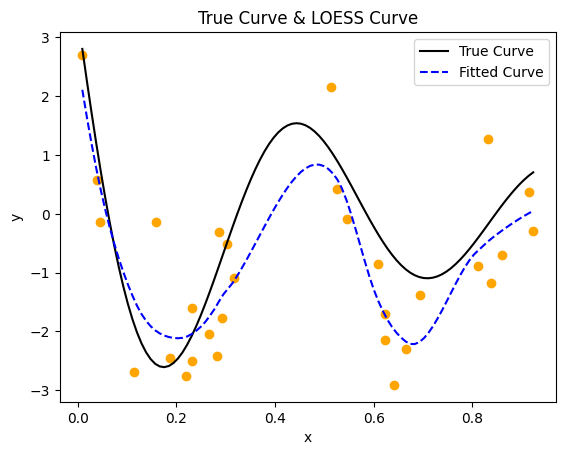

In [ ]:
# True curve function to help with plotting
def true_curve(x):
  return np.sin((12* (x + 0.2))) / (x + 0.2)

# Fit LOESS model with optimal span
optimal_span_model = loess(X, y, span=optimal_spans[0])
optimal_span_model.fit()

# Make Interpolated Denser/Finer Grid of points for plotting
# Interpolation avoids prediction issues when using x range of [0,1]
xs = np.linspace(min(X), max(X), 100)

predicted_values = optimal_span_model.predict(xs)

# Plot LOESS model curve & true curve
plt.scatter(X, y, color='orange')
plt.plot(xs, true_curve(xs), color='black', label='True Curve')
plt.plot(xs, predicted_values, "--", color="blue", label='Fitted Curve')
plt.legend()
plt.title("True Curve & LOESS Curve")
plt.xlabel("x")
plt.ylabel("y")

# Part II: Ridgeless and double descent

## Task 1: Ridgeless Function

In [ ]:
def ridgeless(X_train, Y_train, X_test, Y_test, eps=1e-10):

  # 1. Center the X_train, center X_test, estimate b_0
  X_train_mean = np.mean(X_train, axis=0)
  X_train_centered = X_train - X_train_mean
  X_test_centered = X_test - X_train_mean

  b_0 = np.mean(Y_train)

  #2. Perform SVD on X_train to get X_train = UDV'
  U, D, V_t = np.linalg.svd(X_train_centered, full_matrices=False)

  #3. Number of singular values > than eps
  k = len(D[D>eps])
  valid_indices = D > eps

  # 4. Truncate V and update feature matrix as F = X_train * V_trunc
  V = V_t.T
  V_trunc = V[:, valid_indices]
  F_train = X_train_centered @ V_trunc

  # 5. Compute LS coefficients with F
  alpha_hat = np.diag(np.diag(F_train.T @ F_train)**-1) @ F_train.T @ Y_train

  # 6. Compute prediction on the training data
  Y_train_pred = b_0 + F_train @ alpha_hat

  # 7. Tranform X_test and compute predictions
  F_test = X_test_centered @ V_trunc
  Y_test_pred = b_0 + F_test @ alpha_hat

  # 8. Calculate MSPE for train and test datasets
  train_mspe = np.mean((Y_train - Y_train_pred) ** 2)
  test_mspe = np.mean((Y_test - Y_test_pred) ** 2)

  return train_mspe, test_mspe

## Task 2: Simulation study

In [ ]:
data2 = pd.read_csv("datasets/Coding3_dataH.csv", header=None)
data2.rename(columns={data2.columns[0]: 'Y'}, inplace=True)

In [ ]:
data2.head()

,Y,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
0,3.178054,0.0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.047122,0.0,0.000000,0.0,0.000000
1,3.072693,0.0,0,0.0,-0.007258,0.185217,0.000000,0.001372,0.0,0.0,...,0.000000,0.0,0.0,0.527546,0.000000,0.000000,0.0,0.059271,0.0,0.000000
2,3.546740,0.0,0,0.0,-0.007258,0.185217,0.000000,0.000000,0.0,0.0,...,-0.000028,0.0,0.0,0.527546,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,3.508556,0.0,0,0.0,-0.194452,0.005858,0.168630,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.452800,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,3.589059,0.0,0,0.0,-0.194452,0.005858,0.000004,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.452800,0.003294,0.000000,0.0,0.000000,0.0,0.491547


In [ ]:
data2.shape

(506, 241)

In [ ]:
X = data2.iloc[:, 1:].to_numpy()
y = data2.iloc[:, 0].to_numpy()

mspe_dict = {i: (lambda: [])() for i in range(5, 240)}

for t in range(30):
  # Randomly split data into train (25%) and test (75%)
  X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.75)

  for d in range(5, 240):
    _, test_mspe = ridgeless(X_train[:,:d], Y_train, X_test[:,:d], Y_test)
    mspe_dict[d].append(np.log(test_mspe))

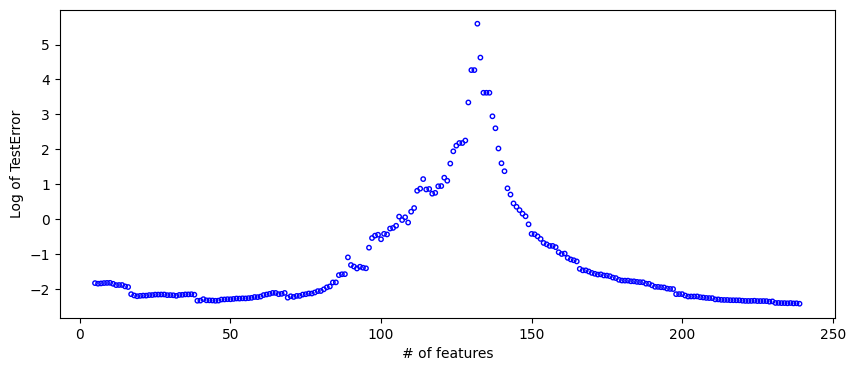

In [ ]:
median_test_mspe = {d: np.median(mspe_dict[d]) for d in range(5, 240)}

x_val = np.array(list(median_test_mspe.keys()))
y_val = np.array(list(median_test_mspe.values()))

plt.figure(figsize=(10, 4))

plt.scatter(x_val, y_val, marker='o', facecolors='none', edgecolors='blue', s=10)
plt.xlabel('# of features')
plt.ylabel('Log of TestError')
plt.show()

# Part III: Clustering time series

In [ ]:
# Reference: https://liangfgithub.github.io/Python_W5_RegressionSpline.html

def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oright, :] = xr @ tt

        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

In [ ]:
data3 = pd.read_csv("datasets/Sales_Transactions_Dataset_Weekly.csv")
new_data3 = data3.iloc[:,1:53]
new_data3.head()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,11,12,10,8,13,12,14,21,6,14,...,4,7,8,10,12,3,7,6,5,10
1,7,6,3,2,7,1,6,3,3,3,...,2,4,5,1,1,4,5,1,6,0
2,7,11,8,9,10,8,7,13,12,6,...,6,14,5,5,7,8,14,8,8,7
3,12,8,13,5,9,6,9,13,13,11,...,9,10,3,4,6,8,14,8,7,8
4,8,5,13,11,6,7,9,14,9,9,...,7,11,7,12,6,6,5,11,8,9


In [ ]:
new_data3.shape

(811, 52)

In [ ]:
# Remove mean from each time series (row-wise mean)
data3_centered = new_data3.apply(lambda row: row - row.mean(), axis=1)
data3_centered.head()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,1.365385,2.365385,0.365385,-1.634615,3.365385,2.365385,4.365385,11.365385,-3.634615,4.365385,...,-5.634615,-2.634615,-1.634615,0.365385,2.365385,-6.634615,-2.634615,-3.634615,-4.634615,0.365385
1,3.019231,2.019231,-0.980769,-1.980769,3.019231,-2.980769,2.019231,-0.980769,-0.980769,-0.980769,...,-1.980769,0.019231,1.019231,-2.980769,-2.980769,0.019231,1.019231,-2.980769,2.019231,-3.980769
2,-1.692308,2.307692,-0.692308,0.307692,1.307692,-0.692308,-1.692308,4.307692,3.307692,-2.692308,...,-2.692308,5.307692,-3.692308,-3.692308,-1.692308,-0.692308,5.307692,-0.692308,-0.692308,-1.692308
3,3.730769,-0.269231,4.730769,-3.269231,0.730769,-2.269231,0.730769,4.730769,4.730769,2.730769,...,0.730769,1.730769,-5.269231,-4.269231,-2.269231,-0.269231,5.730769,-0.269231,-1.269231,-0.269231
4,-0.461538,-3.461538,4.538462,2.538462,-2.461538,-1.461538,0.538462,5.538462,0.538462,0.538462,...,-1.461538,2.538462,-1.461538,3.538462,-2.461538,-2.461538,-3.461538,2.538462,-0.461538,0.538462


## Task 1: Fitting NCS

In [ ]:
# 1. Fit each time series with an NCS with df=10
w = np.arange(1,53)
F = ns(w, df=9, include_intercept=False)
F.shape

(52, 9)

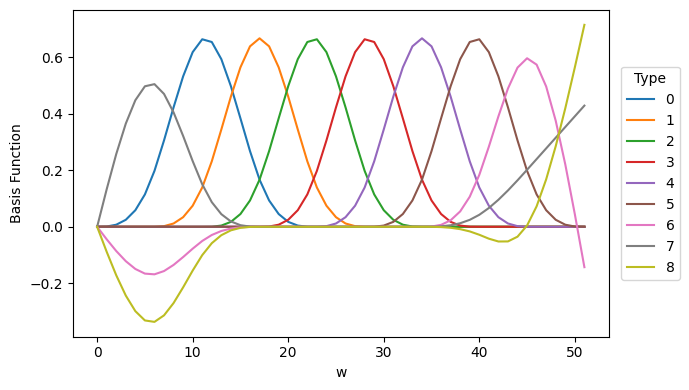

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot(F)
plt.xlabel("w")
plt.ylabel("Basis Function")
plt.legend(range(9), title="Type",
           bbox_to_anchor=(1.01, 0.5), loc="center left")
plt.tight_layout()

In [ ]:
# 2. Store NCV coefficients in B
# 2.1. Remove the column mean from F
F_df = pd.DataFrame(F)
F_new = F_df - F_df.mean(axis=0)

# 2.2. Compute B
B_t = np.linalg.inv(F.T @ F) @ F.T @ data3_centered.T
B = B_t.T
B.shape

(811, 9)

## Task 2: Cluster Matrix B

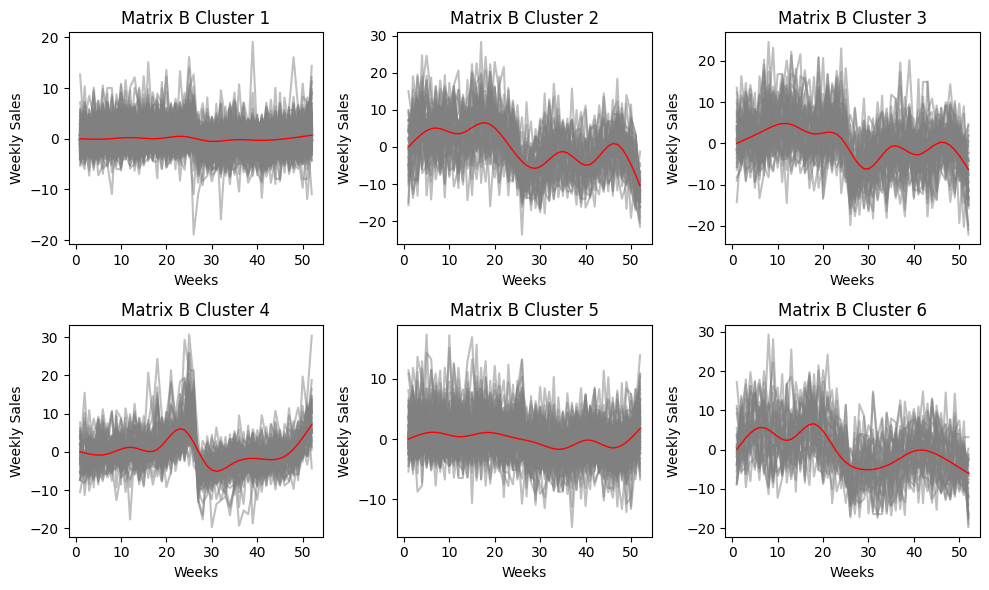

In [ ]:
# 1. Cluster B into 6 clusters
kmeans = KMeans(n_clusters=6, random_state=7754).fit(B)

# 2. Visualize clusters
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 6))

for i in range(1, 7):

    plt.subplot(2, 3, i)

    # 2.1. Visualize the centered time series
    cluster_ts = data3_centered[labels == (i-1)]

    for index, row  in cluster_ts.iterrows():
      plt.plot(w, row, color='grey', alpha=0.5)

    # 2.2. Visualize cluster centers
    centers = F @ cluster_centers[i-1]
    plt.plot(w, centers, color='red', linewidth=1)

    plt.title(f"Matrix B Cluster {i}")
    plt.xlabel("Weeks")
    plt.ylabel("Weekly Sales")

plt.tight_layout()
plt.show()

## Task 3: Cluster Matrix X

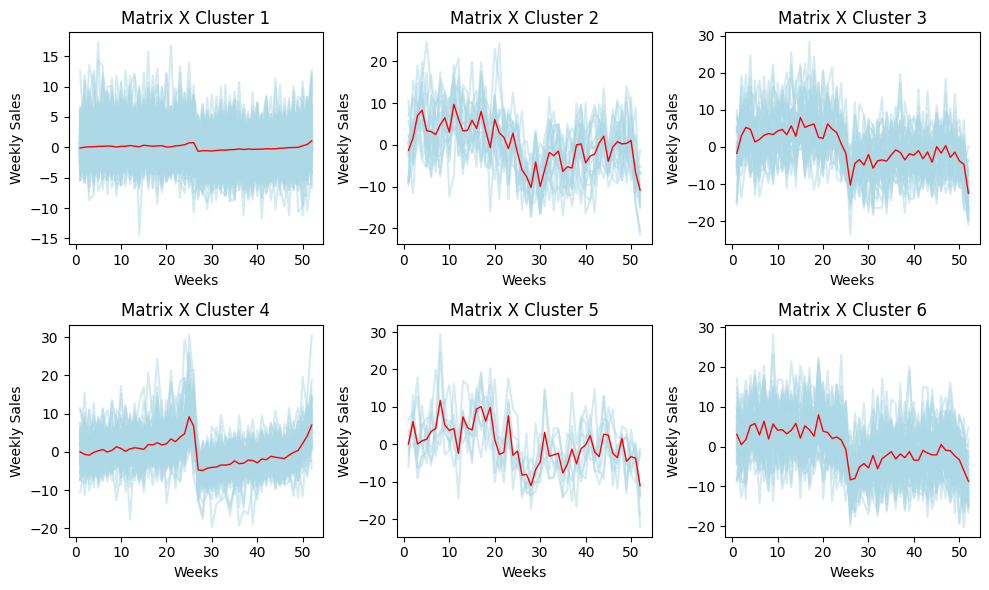

In [ ]:
# 1. Cluster B into 6 clusters
kmeans = KMeans(n_clusters=6, random_state=7754).fit(data3_centered)

# 2. Visualize clusters
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(10, 6))

for i in range(1, 7):

    plt.subplot(2, 3, i)

    # 2.1. Visualize the centered time series
    cluster_ts = data3_centered[labels == (i-1)]

    for index, row  in cluster_ts.iterrows():
      plt.plot(w, row, color='lightblue', alpha=0.5)

    # 2.2. Visualize cluster centers
    plt.plot(w, cluster_centers[i-1], color='red', linewidth=1)

    plt.title(f"Matrix X Cluster {i}")
    plt.xlabel("Weeks")
    plt.ylabel("Weekly Sales")

plt.tight_layout()
plt.show()